# Notebook description

This notebook describes the step-by-step discovery process of creating the needed resources for creating and managing S3 buckets in AWS.
It is not supposed to be necessarily used for creating said infrastructure, but serves more as a visual tool for individuals who want to troubleshoot simple AWS starter problems with the Python SDK.
For ground-up set-up of the AWS infra, refer to the cdk portion of these tutorials, futher described in the Project `README.md`.

The implemented resources will be the following.

- Attach policies for a user to execute needed actions
    - Create Roles
    - Create Policies (important! This is how we manage what we "can do")
    - Attach Policies to Roles and Users.
- Create Role for S3 management
- Attach create, list, delete permissions for this user
- Create a bucket in S3
- Upload a data set to that bucket 
- Dowload and query it

The code will mostly use the SDK `boto3` as it is easier to run in a cell-by-cell manner. 
The infrastructure will be built modularly, with each step and process building on the next one.
At the end of the notebook you should have all of the necessary infra setup. 
I will also attach instructions to run these full processes in one go in separate Python files. 
I will do them with both the Python SDK and CDK in files `s3_infra_sdk.py`, and `s3_stack.py`. 
With them you should be able to run them with simple commands, but that is better described in the README.md 


#### Prerequisites

Make sure that you have setup and your accounts as per the README instructions, and have a user. I called mine `s3-tutorials`.
This includes setting up the AWS CLI with your own private access keys.
Install also the `requirements.txt`-file that allows you to run this notebook.


Plan: 
- [x] User policies and access --> add only access for one user
- [x] S3 Bucket create
- [  ] S3 Object put, get 
- [  ] S3 Destroy bucket
- [  ] S3 Select
- [  ] For S3 Select 
    - comparison it might be useful to try to dump a larger object to be able to compare the performance between S3 load to polars (also comp. pands) and S3 select
- [  ] Other:
    - Monitoring?
    - Lifecycle
    - Check the demos for other ideas

---
## Setting up the resources

Lets start with the trying to setup and access our S3 environments. This should all be accessible with the `boto3` library. 

In [15]:
import json

import boto3
from botocore.exceptions import ClientError

We can access S3 by creating a `boto3` client



In [2]:
# Create an S3 client
s3 = boto3.client('s3')

And now we should have all the necessary methods for our use:

In [16]:
dir(s3)[-4:]

['upload_part',
 'upload_part_copy',
 'waiter_names',
 'write_get_object_response']

For example, lets try to list all buckets in our S3:

In [17]:
response = s3.list_buckets()

ClientError: An error occurred (AccessDenied) when calling the ListBuckets operation: Access Denied

It seems that some error occured and that I dont have permissions to list S3 buckets. 
This should make sense, since I have only created a user but not attached any policies to it.
We actually dont even have any roles attached, just a user in AWS.
We cant actually check this via code, because we dont have permissions to do anything. 
The only options would be to navigate to the console and check the permissions under our user.

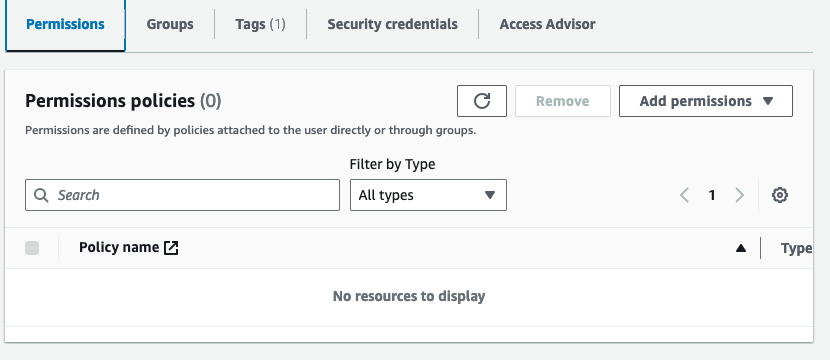

We clearly have no permissions. Actually, we dont even have a role to attach any access policies. 
Roles are nice because we can attach permissions to certain roles without further explicit sharing of security credentials.
Without roles, i would have to hardcode my access keys to be able to initiate sdk sessions.


#### Solution

We will first create an IAM role `S3PracticeRole`, after which we will attach "list buckets" permissions.
Although I know that we will later attach a lot more permissions, we will start off with these - it is good practice to attach only permissions that are needed for particular actions. 
We can do this with the IAM Client.

However, since we are starting from scratch, there are several problems: I want to cannot attach bucket policies to a role, if i have no roles, *AND* I cannot create a role if i have not allowed my user a permission to create roles. 
Therefore, I need to setup up the following things:

1. Permissions for my user to create roles (create policy + attach to user)
2. A policy for being able to create a bucket
3. Attach it to my role


We will create policy JSONs that we attach to the needed resources.
For more information about those, check the [AWS Policy JSONs docs](https://docs.aws.amazon.com/IAM/latest/UserGuide/reference_policies.html).
The create role policy can be seen attached in the file `user_policy.json`. 
It allows me to setup, attach, get, and delete basic policies with IAM.
With it we will only create one role, `S3TutorialsSetupPolicies`.
The rest will be setup with the SDK (`boto3`), as we want to practice using it as extensively as possible.


Here I "cheated" a bit. I could not use the `iam.create_policy` method without any policies. Hence i could not use the SDK as is. I could have probably done this with the CLI or CDK but I just wanted to get quickly started so I just created a policy in the AWS Console and attached it to my user. Below is the policy json. It allows the user to create any new role.


And now lets move on to creating the new role. You can name the role however you want. Remember to set the `arn_number` as your own user ARN - I have removed mine for privacy sake.
The other variables are defined as below, but will eventually be moved to a config yaml file.

In [134]:
# Setups
user_name = 's3-tutorials'
role_name = 'S3PracticeRole'
arn_number = ""
arn_base = f"arn:aws:iam::{arn_number}"
bucket_name = "visitor-data-finland"

policy_names = {
    "base": "S3TutorialsSetupPolicies",
    "buckets": "ManageBuckets",
    "assume_role": "AssumeRolePolicy"
}


And below I have defined two helper functions: 
- Use check that I have added correct actions to certain policies.
- Delete a policy from a role

In [135]:

def print_policy_actions(iam_client, policy_name, arn_number=arn_number, version="v1"):
    arn = f"arn:aws:iam::{arn_number}:policy/{policy_name}"

    # Get policy version details
    version_response = iam_client.get_policy_version(PolicyArn=arn, VersionId=version)

    # Extract and print the actions from the policy version
    actions_list = []
    for statement in version_response['PolicyVersion']['Document']['Statement']:
        actions = statement.get('Action', [])
        if isinstance(actions, str): # some policies only have only action
            actions_list.append(actions)
        else:
            actions_list += actions
    print(f"Actions allowed for {policy_name}: {actions_list}")

def delete_policy(iam_client, policy_name, attached_roles=[], attached_user=None, arn_base=arn_base):
    policy_arn = f'{arn_base}:policy/{policy_name}'

    # Detach the policy from IAM roles
    for role in attached_roles:
        iam_client.detach_role_policy(
            RoleName=role,
            PolicyArn=policy_arn
        )

    if attached_user:
        # Detach the policy from IAM User
        iam_client.detach_user_policy(
            UserName=attached_user,
            PolicyArn=policy_arn
        )

    # Delete the policy
    iam_client.delete_policy(PolicyArn=policy_arn)

    print(f"Policy '{policy_name}' deleted successfully.")


An for example, below we can print the actions that we have set for our base AWS user

In [136]:
# # Create an IAM client
iam = boto3.client('iam')
print_policy_actions(iam, policy_names['base'])

Actions allowed for S3TutorialsSetupPolicies: ['iam:AttachRolePolicy', 'iam:AttachUserPolicy', 'iam:CreatePolicy', 'iam:CreatePolicyVersion', 'iam:CreateRole', 'iam:DeletePolicy', 'iam:DetachRolePolicy', 'iam:GetPolicy', 'iam:GetPolicyVersion', 'iam:GetRole', 'iam:SetDefaultPolicyVersion']


### Creating a Role `S3PracticeRole`

The next step is to create roles that we can attach the S3 action permissions to.
In theory, we **could** just attach all of these permissions to the user, but managing roles is more specific-defined and allows for varying permission definition (e.g a user can have many roles).
Here is what ChatGPT had to say about using roles vs users:

> In general, it's recommended to use IAM roles for granting permissions whenever possible, as they provide more flexible and secure control of AWS resources. IAM roles are particularly useful for cross-account access, granting permissions to AWS services to carry out actions on your behalf, and for users who need temporary access to resources or to perform specific tasks.


When creating the role, we will also create a policy allowing our AWS user to assume this role (`sts:AssumeRole`).

In [142]:
# # Create an IAM client
iam = boto3.client('iam')

policy_for_role = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {"AWS": f"{arn_base}:root"},
            "Action": ["sts:AssumeRole"]
        }
    ]
}

#  Create a new IAM role. If already created, pass
try:
    response = iam.create_role(
        RoleName=role_name,
        Description='Role for S3 practice',
        AssumeRolePolicyDocument=json.dumps(policy_for_role)
    )
    print(f"Role '{role_name}' created successfully.")
except ClientError as e:
    print(e)

Role 'S3PracticeRole' created successfully.


In [143]:
# For debugging: Delete the IAM role
# iam.delete_role(RoleName=role_name)

# print(f"IAM role '{role_name}' deleted successfully.")

### Policies for managing buckets

Next lets create the bucket policy that allows us to create a bucket, and attach it to our role. 
The wildcard allows for the creation of types and names of buckets, which is good for our sandboxing case.

You could version these policies, but personally I do not like that for this tutorial - for the purpose of this tutorial, it is easier to manage v1 policies only. 
If I need to update a policy, I will just delete the policy with the helper function `delete_policy` and run the cell below again.

In [144]:
create_buckets_policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "s3:CreateBucket",
                "s3:ListBuckets",
                "s3:ListAllMyBuckets",
                "s3:DeleteBucket"
            ],
            "Resource": "*"
        }
    ]
}

name = policy_names["buckets"]

try:
    iam = boto3.client('iam')
    
    # Create the policy
    policy = iam.create_policy(
    PolicyName=name,
    PolicyDocument=json.dumps(create_buckets_policy)
    )
    
    # Attach the policy to the role
    response = iam.attach_role_policy(
        RoleName=role_name,
        PolicyArn=policy['Policy']['Arn']
    )

    act_desc = create_buckets_policy["Statement"][0]["Action"]
    print(f"Policy added to role {role_name} with action: {act_desc}")
except ClientError as e:
    print(e)

Policy added to role S3PracticeRole with action: ['s3:CreateBucket', 's3:ListBuckets', 's3:ListAllMyBuckets', 's3:DeleteBucket']


There remains one final obstacle before we can create the bucket: we have configured our SDK for our **user**, but given S3 permissions to our role --> we need to allow the user to be able to *assume* the S3 role and use it. To do this, we need (once again), an attached user policy:

In [145]:
# Policy document granting permission to assume S3PracticeRole
role_name
assume_role_policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": "sts:AssumeRole",
            "Resource": f"{arn_base}:role/{role_name}"
        }
    ]
}
# policy_document
try:
    # Create IAM policy
    response = iam.create_policy(
        PolicyName=policy_names["assume_role"],
        PolicyDocument=json.dumps(assume_role_policy),
        Description='Policy allowing IAM user to assume S3PracticeRole'
    )

    # Attach the policy to the IAM user
    iam.attach_user_policy(
        UserName=user_name,
        PolicyArn=response['Policy']['Arn']
    )

    print(f"Policy '{response['Policy']['PolicyName']}' attached to IAM user '{user_name}'.")

except Exception as e:
    print(e)


Policy 'AssumeRolePolicy' attached to IAM user 's3-tutorials'.


### Creating a bucket

Now we should be able to create buckets into S3. Lets try this by creating a bucket with the name of our data, `visitor-data-finland`:

In [127]:
def role_s3_client(role_name, arn_base=arn_base):
    sts = boto3.client('sts')
    response = sts.assume_role(
        RoleArn=f"{arn_base}:role/{role_name}",
        RoleSessionName=role_name
    )
    role_credentials = response['Credentials']

    # Create an S3 client
    s3 = boto3.client('s3',
        aws_access_key_id=role_credentials['AccessKeyId'],
        aws_secret_access_key=role_credentials['SecretAccessKey'],
        aws_session_token=role_credentials['SessionToken']
    )
    return s3

In [146]:
# role_arn = f"{arn_base}:role/{role_name}"
region = "eu-north-1"

try:
    s3 = role_s3_client(role_name)

    bucket_name = "visitor-data-finland"  # has to be unique

    # Create the S3 bucket
    s3.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={
            'LocationConstraint': region  # same as our default region
        }
    )
    print(f"S3 bucket '{bucket_name}' created successfully.")

except Exception as e:
    print(e)
    # pass

S3 bucket 'visitor-data-finland' created successfully.


Now we should have an S3 bucket created called `visitor-data-finland`. You can confirm this by checking it in the S3 console, or by listing the buckets in S3, which we tried to do at the start of this notebook:

In [148]:
response = s3.list_buckets()
response
print("Found buckets:")
for bucket in response['Buckets']:
    print(f'\t{bucket["Name"]}')

Found buckets:
	visitor-data-finland


We have exactly one bucket, which is the one that we just made.

Finally, if we want to cleanup everything, we can delete roles and role policies with the following code block. 
If you want to keep the infrastructure, you can just skip the cells or make sure that the flag `clean` is not true.

In [149]:
clean = True

if clean:
    try:
        s3 = role_s3_client(role_name)

        s3.delete_bucket(Bucket=bucket_name)
        print(f"S3 bucket '{bucket_name}' deleted successfully.")

        delete_policy(iam, policy_names["buckets"], attached_roles=[role_name])

        # Delete the IAM role
        iam.delete_role(RoleName=role_name)
        print(f"IAM role '{role_name}' deleted successfully.")

        # Delete assume role policy from user
        delete_policy(iam, policy_names["assume_role"], attached_user=user_name)
    except Exception as e:
        print(e)


S3 bucket 'visitor-data-finland' deleted successfully.
Policy 'ManageBuckets' deleted successfully.
IAM role 'S3PracticeRole' deleted successfully.
Policy 'AssumeRolePolicy' deleted successfully.


---

# Uploading data to our bucket

The next steps that we can try is uploading a data object into our bucket. 
We will do this by uploading a dataset of visitor data that we pre-loaded. 
The pre-processed and cleaned dataset should be found in `data/visitor_data.csv`.
Instructions for fetching and generating the data can be found in `data.ipynb`.

We start off by loading our dataset:

In [ ]:
import pandas as pd

In [ ]:
data_name = "visitor_data"
data = pd.read_csv(f"data/{data_name}.csv")
data.head()

,year_month,total,EU-28,Skandinavia,Asia,Oceania,Africa,Americas,Russia,Germany,...,Tsekki,Turkey,Ukraine,Hungary,Uruguay,New Zealand,Belarus,Venezuela,Vietnam,Muut maat
0,1995-01-01,75195,41311,17791,4171,272,172,3825,18082,6411,...,243,83,56,278,1,25,32,54,11,232
1,1995-02-01,72455,41489,18117,4444,208,148,4265,13939,8643,...,211,121,243,313,0,27,82,26,2,222
2,1995-03-01,93451,53894,25329,4631,350,201,5706,18079,8922,...,213,154,70,349,2,25,20,44,7,232
3,1995-04-01,76014,44103,21009,4154,351,265,5127,13472,5733,...,310,129,56,238,5,24,19,19,13,237
4,1995-05-01,115716,71598,35488,7968,880,404,8916,13707,14107,...,487,254,46,417,11,122,39,49,30,425


Perfect. We have time series of visitors to Finland, partitioned into regions.
If we want to upload the data to the S3 bucket, it will be saved there as an object. 
This is again done with the help of `boto3`. 